# Evaluation

In [1]:
cd ~/Documents/food/Food_project/

/home/serge/Documents/food/Food_project


In [2]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import roc_auc_score,confusion_matrix
from tqdm import tqdm

print(tf.__version__)

1.13.1


In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
%env CUDA_VISIBLE_DEVICES=0,1
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)


sess = tf.Session(config=config)

set_session(sess)
tf.random.set_random_seed(123)
np.random.seed(123)

env: CUDA_VISIBLE_DEVICES=0,1


Using TensorFlow backend.


In [4]:
im_directory = "./Food_photos_copy"
fine_to_coarse = pd.read_csv("fine_to_coarse.csv",encoding = "utf-8")
coarse_labels = fine_to_coarse["Coarse names"]
coarse_labels = list(coarse_labels.to_numpy())

data = pd.read_pickle("./data.pkl")

In [5]:
# split dataset into train & val
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.15,random_state=123)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20, 
                                   zoom_range=[1.1,1.6],
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip = True,
                                  validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train, directory=im_directory, x_col='name', y_col='coarse labels',subset="training", target_size=(224, 224), color_mode='rgb', classes=coarse_labels, class_mode='categorical', batch_size=32, shuffle=True, seed=123, save_to_dir=None, save_prefix='', save_format='png', interpolation='nearest', drop_duplicates=True)
val_generator = train_datagen.flow_from_dataframe(train, directory=im_directory, x_col='name', y_col='coarse labels',subset="validation", target_size=(224, 224), color_mode='rgb', classes=coarse_labels, class_mode='categorical', batch_size=1, shuffle=False, seed=123, save_to_dir=None, save_prefix='', save_format='png', interpolation='nearest', drop_duplicates=True)
test_generator = test_datagen.flow_from_dataframe(test, directory=im_directory, x_col='name', y_col='coarse labels', target_size=(224, 224), color_mode='rgb', classes=coarse_labels, class_mode='categorical', batch_size=1, shuffle=False, seed=123, save_to_dir=None, save_prefix='', save_format='png', subset=None, interpolation='nearest', drop_duplicates=True)

Found 5250 images belonging to 22 classes.
Found 1312 images belonging to 22 classes.
Found 1159 images belonging to 22 classes.


In [7]:
from keras.models import model_from_json
name = "mobilenet_dense"
# Model reconstruction from JSON file
with open('models/'+name+'_architecture.json', 'r') as f:
    model_best = model_from_json(f.read())

# Load best weights into the new model
model_best.load_weights('models/'+name+'_weights.hdf5')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
train_generator.reset()
batches = len(train_generator)
batch_size = 32

train_pred = np.zeros((train_generator.n,22))
train_true = np.zeros((train_generator.n,22))

for batch in tqdm(range(batches)):
    x, y = next(train_generator)
    train_pred[batch * batch_size : min(train_generator.n,(batch+1) * batch_size)] = np.asarray(model_best.predict(x))
    train_true[batch * batch_size : min(train_generator.n,(batch+1) * batch_size)] = y

100%|██████████| 165/165 [01:46<00:00,  1.55it/s]


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve

def max_accuracy(y_true,probs):
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    accuracy_scores = []
    for thresh in thresholds:
        acc = balanced_accuracy_score(y_true,[1 if m > thresh else 0 for m in probs])
#         acc = accuracy_score(y_true,[1 if m > thresh else 0 for m in probs])
        accuracy_scores.append(acc)
    accuracies = np.array(accuracy_scores)
    max_acc = accuracies.max() 
    max_acc_thresh =  thresholds[accuracies.argmax()]
    return max_acc,max_acc_thresh

threshs = []
for i in tqdm(range(22)):
    y_true = train_true[:,i]
    y_score = train_pred[:,i]
    max_acc,max_acc_thresh = max_accuracy(y_true,y_score)
    threshs.append(max_acc_thresh)

100%|██████████| 22/22 [01:39<00:00,  4.43s/it]


In [10]:
from sklearn.metrics import roc_curve

def per_class_metrics(labels,preds,threshs):
    accs = []
    aucs = []
    sensitivities = []
    specificities = []
    rocs = []
    for i in range(22):
        y_true = labels[:,i]
        y_score = preds[:,i]
        pred_bool = y_score>threshs[i]
#         pred_bool = y_score>0.5
        tn, fp, fn, tp = confusion_matrix(y_true, pred_bool).ravel()
        specificity = tn / (tn+fp)
        sensitivity = tp/(tp+fn)
        acc = np.mean(pred_bool == y_true)
        roc = roc_curve(y_true,y_score)
        
        accs.append(acc)
        aucs.append(roc_auc_score(y_true,y_score))
        rocs.append(roc)
        specificities.append(specificity)
        sensitivities.append(sensitivity)
    return accs,aucs,sensitivities,specificities,rocs

In [11]:
def get_labels_and_preds(model,generator):
    generator.reset()
    preds = model.predict_generator(generator,steps=len(generator))
    labels = [[True if i in row else False for i in range(22)] for row in generator.classes]
    labels = np.array(labels)
    return labels,preds

val_true,val_pred = get_labels_and_preds(model_best,val_generator)
test_true,test_pred = get_labels_and_preds(model_best,test_generator)

In [12]:
train_labels = train_generator.labels
train_labels_flat = np.array([y for x in train_labels for y in x])
train_counts = np.bincount(train_labels_flat)

accs_val,aucs_val,sens_val,spec_val,rocs_val = per_class_metrics(val_true,val_pred,threshs)
accs_test,aucs_test,sens_test,spec_test,rocs_test = per_class_metrics(test_true,test_pred,threshs)

coarse_labels = sorted(list(val_generator.class_indices.keys()))

metrics_val = pd.DataFrame(
    {'Classes': coarse_labels,
     'Training Examples': train_counts,
     'AUC': aucs_val,
     'Accuracy': accs_val,
     'Sensitivity':sens_val,
     'Specificity': spec_val
    })

metrics_val = metrics_val[['Classes','Training Examples', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity']]

metrics_test = pd.DataFrame(
    {'Classes': coarse_labels,
     'Training Examples': train_counts,
     'AUC': aucs_test,
     'Accuracy': accs_test,
     'Sensitivity': sens_test,
     'Specificity': spec_test, 
    })
metrics_test = metrics_test[['Classes','Training Examples', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity']]

metrics_val.to_csv("metrics_val.csv",index=False)
metrics_test.to_csv("metrics_test.csv",index=False)

metrics_test

,Classes,Training Examples,AUC,Accuracy,Sensitivity,Specificity
0,Bread,625,0.933370,0.891286,0.873333,0.893954
1,Burger,222,0.862092,0.911993,0.555556,0.929412
2,Cereal/Cereal bar,41,0.842148,0.950820,0.750000,0.952215
3,Cheese,597,0.863290,0.846419,0.693333,0.869177
4,Desserts/Sweet snacks,373,0.822422,0.791199,0.694444,0.797608
5,Dressing,1989,0.834985,0.746333,0.766595,0.732659
6,Drink,1851,0.943683,0.894737,0.871046,0.907754
7,Fried sides,791,0.971703,0.911993,0.922652,0.910020
8,Fruit,421,0.884825,0.922347,0.670455,0.943044
9,Meats,1271,0.822533,0.779983,0.684211,0.805921


Text(0, 0.5, 'Sensitivity on the test set')

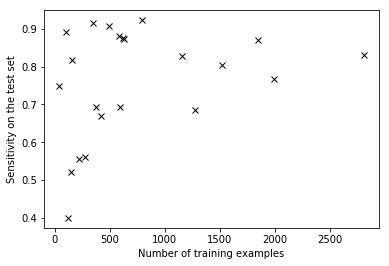

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_counts,sens_test,'kx')
plt.xlabel("Number of training examples")
plt.ylabel("Sensitivity on the test set")

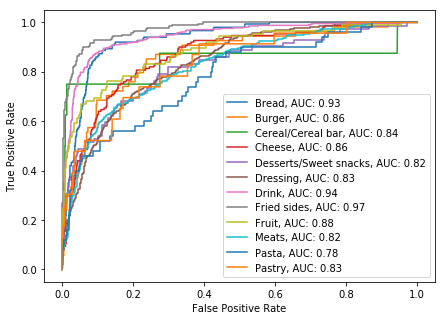

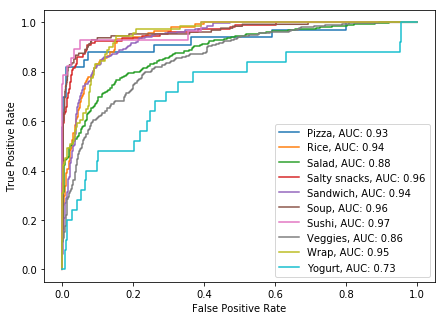

In [15]:
# plot example test roc curve

plot_legend = [coarse_labels[i]+', AUC: ' + '{:.2f}'.format(aucs_test[i]) for i in range(22)]
plt.figure(figsize=(7,5))
for cat in range(0,12):
    fpr = rocs_test[cat][0]
    tpr = rocs_test[cat][1]
    plt.plot(fpr,tpr)
plt.legend(plot_legend[0:12],loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC1.png')

plt.figure(figsize=(7,5))
for cat in range(12,22):
    fpr = rocs_test[cat][0]
    tpr = rocs_test[cat][1]
    plt.plot(fpr,tpr)
plt.legend(plot_legend[12:22],loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC2.png')

In [ ]:
val_pred_bool = val_pred>threshs
test_pred_bool = test_pred>threshs

def get_predictions_df(generator,pred_bool):
    generator.reset()
    predictions=[]
    labels = generator.class_indices
    labels = dict((v,k) for k,v in labels.items())
    for row in pred_bool:
        l=[]
        for index,cls in enumerate(row):
            if cls:
                l.append(labels[index])
        predictions.append(",".join(l))

    filenames= generator.filenames
    results=pd.DataFrame({"Filename":filenames,
                          "Predictions":predictions})
    return results

results_val = get_predictions_df(val_generator,val_pred_bool)
results_test = get_predictions_df(test_generator,test_pred_bool)

In [ ]:
def display_images_and_predictions(results,im_directory,N=100):

    from IPython.display import Image,display
    for index,row in results.iloc[:100].iterrows():
        prediction = row["Predictions"]
        display(Image(filename=os.path.join(im_directory,row["Filename"])))
        print(prediction)

# display_images_and_predictions(results_val,im_directory,N=50)

display_images_and_predictions(results_test,im_directory,N=50)